# Plotting Data


Data in PyMoDAQ are featured with a lot of metadata, allowing their proper
description and enabling seamlessly saving/loading to hdf5 files. But what about representation?
Analysis? Exploration?

With Python you usually do this by writing a script and manipulate and plot your data using your
favorite backend (matplotlib, plotly, qt, tkinter, ...) However because PyMoDAQ is highly graphical
you won't need that. PyMoDAQ is featured with various data viewers allowing you to plot any
kind of data. You'll see below some nice examples of how to plot your PyMoDAQ's data using the builtin
data viewers.

.. note::
  To execute this notebook properly, you'll need PyMoDAQ >= 4.0.2 (if not released yet, you can get it from github)

## Plotting scalars: Viewer0D

Scalars or `Data0D` data are the simplest form of data. However, just displaying numbers is somewhat lacking (in particular when one want to compare data evolution over time, or parameter change...). This is why it is important to keep track of the history of the scalar values. The `Viewer0D`, see below, has such an history as well as tools to keep track of the maximal reached value.

In [1]:
%gui qt
import numpy as np

from pymodaq_gui.plotting.data_viewers.viewer0D import Viewer0D
from pymodaq_data.data import DataRaw

dwa = DataRaw('my_scalar', data=[np.array([10.6]), np.array([-4.6])], labels=['scalar1', 'scalar2'])
viewer0D = Viewer0D()


In [2]:
viewer0D.show_data(dwa)

![Showing scalars](plotting_data/viewer0D_simple.png)

Well not much can be seen except for the numbers printed on the right (shown by clicking on the dedicated button ![](plotting_data/viewer0D_123.png)). But what if I call several time the `show_data` method to display evolving signal?

.. note::
  We recall that a `DataRaw` is a particular case of a more generic DataWithAxes (*dwa* in short) having its source set to *raw* 

In [3]:
for ind in range(100):
    dwa = DataRaw('my_scalar', data=[np.sin([ind / 100 * 2*np.pi]),
                                     np.sin([ind / 100 * 2*np.pi + np.pi/4])],
                 labels=['mysinus', 'my_dephased_sinus'])
    viewer0D.show_data(dwa)

![Showing an history of scalars, together with their min and max values (dashed lines)](plotting_data/viewer0D_sinus.png)

You immediately see the usefulness of such an history, allowing for instance to optimize signals when tweaking a parameter especially if you use the dashed lines, triggered by ![Min/Max dashed lines](plotting_data/viewer0D_min_max.png), showing the values of the min and max reached values.


## Plotting vectors/waveforms: Viewer1D

When increasing complexity, one get one dimensional data. It has one more important metadata, its axis. Properly defining the data object will translate into rich plots:

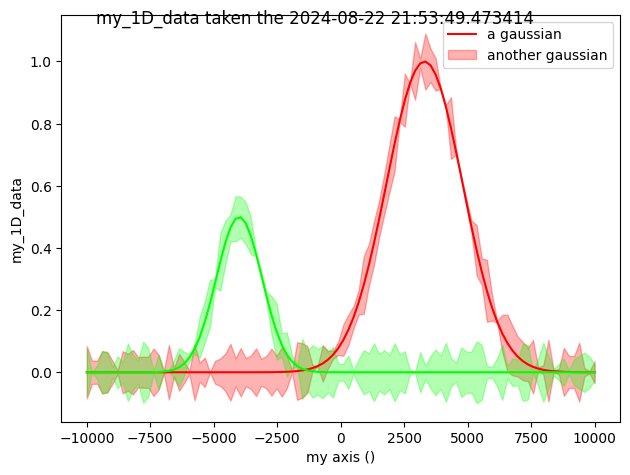

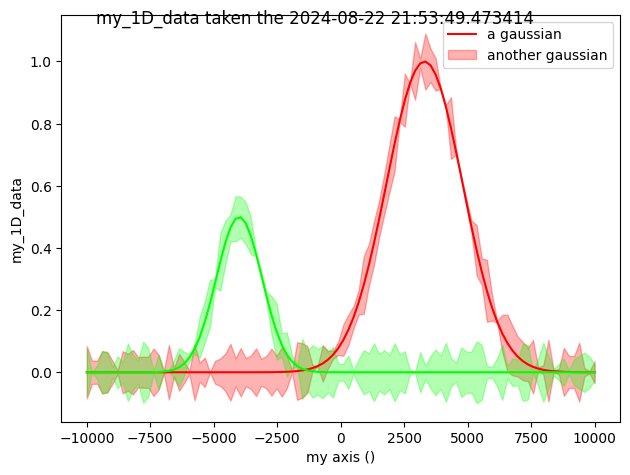

In [5]:
from pymodaq_utils import math_utils as mutils
from pymodaq_data.data import Axis

axis = Axis('my axis', units='my units', data=np.linspace(-10000, 10000, 100))

dwa1D = DataRaw('my_1D_data', data=[mutils.gauss1D(axis.get_data(), 3300, 2500),
                                    mutils.gauss1D(axis.get_data(), -4000, 1500) * 0.5],
                labels=['a gaussian', 'another gaussian'],
                axes=[axis],
                errors=[0.1* np.random.random_sample((axis.size,)) for _ in range(2)])
dwa1D.plot('matplotlib')

..note::
  One can directly call the method `plot` on a data object, PyMoDAQ will determine which data viewer to use.

![Showing Data1D](plotting_data/viewer1D.png)

You can see the legends correspond to the data labels, while the axis shows both the label and the units in scientific notation (notice the k before 'my units' standing for kilo).

As for the buttons in the toolbar (you can try them from the notebook):

* ![Showing Data1D](plotting_data/viewer1D_roi.png): opens the ROI (region of interest) manager, to load, save and define ROI to apply to the data. This will create croped Data1D and Data0D for the application of an operation on the croped data such as *mean*, *sum*, *std*... See figure below, showing the mean value on the bottom panel. ROI can be applied to one of the trace or to both as reflected by the legends
* ![Showing Data1D](plotting_data/viewer1D_crosshair.png): activate the croshair (yellow vertical line) that can be grabed and translated. The data at the crosshair position is printed on the right of the toolbar.
* ![Showing Data1D](plotting_data/viewer1D_zoom.png): fix the horizontal/vertical aspect ratio (usefull for xy plot see below)
* ![Showing Data1D](plotting_data/viewer1D_dot.png): as shown on the figure below, one can switch between solid line or only dots.
* ![Showing Data1D](plotting_data/viewer1D_xy.png): when data contains two waveforms, using this button will display them in XY mode.
* ![Showing Data1D](plotting_data/viewer1D_overlay.png): when activated, an overlay of the current data will be depicted with a dash line.
* ![Showing Data1D](plotting_data/viewer1D_errors.png): when activated, will display errors (error bars) in the form of a area around the curve
* ![Showing Data1D](plotting_data/viewer1D_sort.png): if the axis data is not monotonous, data will be represented as a scrambled solid line, using this button will reorder the data by ascending values of its axis. See below and figure xx
* ![Showing Data1D](plotting_data/viewer1D_roi_select.png): extra ROI that can be used independantly of the ROI manager

![Showing Data1D](plotting_data/viewer1D_with_roi_crosshair_dot.png)

If errors are defined in the data object, the Viewer1D can easily plot them:

![Showing Data1D](plotting_data/viewer1D_errors_plot.png)


If the axis data is not monotonous, data will be represented as a scrambled solid line, for instance:

In [6]:
axis_shuffled_array = axis.get_data() 
np.random.shuffle(axis_shuffled_array)
axis_shuffled = Axis('my axis', units='my units', data=axis_shuffled_array)

dwa = DataRaw('my_1D_data', data=[mutils.gauss1D(axis_shuffled.get_data(), 3300, 2500),
                                  mutils.gauss1D(axis_shuffled.get_data(), -4000, 1500) * 0.5],
              labels=['a gaussian', 'another gaussian'],
              axes=[axis_shuffled])
dwa.plot('qt')

![Showing Data1D Spread](plotting_data/viewer1D_shuffled.png)

The scrambled lines (left) still represents Gaussians, it is just that the random ordering scrambled the lines. If one remove the lines by clicking the `dot only` button, the Gaussians reappear (middle). They reappear also after pressing the sort button (right).

## Plotting 2D data

2D data can be either an image (pixels on a regular grid) or as a collection of scalars with XY coordinates. PyMoDAQ introduce therefore the notion of "uniform" data for the former and "spread" data for the later. They can however be transparently plotted on the same `Viewer2D` data viewer. One will first show both cases before discussing the `Viewer2D` toolbar.  

### Uniform data
Let's generate data displaying a 2D Gaussian distribution:

In [7]:
# generating uniform 2D data
NX = 100
NY = 50
x_axis = Axis('xaxis', 'xunits', data=np.linspace(-20, 20, NX), index=1)
y_axis = Axis('yaxis', 'yunits', data=np.linspace(20, 40, NY), index=0)

data_arrays_2D = [mutils.gauss2D(x_axis.get_data(), -5, 10, y_axis.get_data(), 25, 2) +
                  mutils.gauss2D(x_axis.get_data(), -5, 5, y_axis.get_data(), 35, 2) * 0.01,
                 mutils.gauss2D(x_axis.get_data(), 5, 5, y_axis.get_data(), 30, 8)]
data2D = DataRaw('data2DUniform', data=data_arrays_2D, axes=[x_axis, y_axis],
                labels=['red gaussian', 'green gaussian'])
data2D.plot('qt')

![Showing Data2D](plotting_data/viewer2D_uniform.png)

The bottom and left axes correspond to the image pixels while the left and top one correspond to the real physical axes defined in the data object. When several arrays are included into the data object, they will be displayed as RGB layers. Data visibility can be set using the red/green (blue) buttons. If only one array is used, the color will be white.

### Spread Data

Spread 2D data are typically what you get when doing a `Spread` or `Tabular` 2D scan, see :ref:`scanner_paragrah`. By the way, `Spread` or `Tabular` 1D scan would typically give the scrambled plot on figure :numref:`XXX`. Let's generate and plot such 2D data

In [8]:
# generating Npts of spread 2D data
N = 100
x_axis_array = np.random.randint(-20, 50, size=N)
y_axis_array = np.random.randint(20, 40, size=N)
x_axis = Axis('xaxis', 'xunits', data=x_axis_array, index=0, spread_order=0)
y_axis = Axis('yaxis', 'yunits', data=y_axis_array, index=0, spread_order=1)

data_list = []
for ind in range(N):
    data_list.append(mutils.gauss2D(x_axis.get_data()[ind], 10, 15,
                                    y_axis.get_data()[ind], 30, 5))
data_array = np.squeeze(np.array(data_list))

data2D_spread = DataRaw('data2DSpread', data=[data_array],
                         axes=[x_axis, y_axis],
                         distribution='spread',
                         nav_indexes=(0,))
data2D_spread.plot('qt')

![Showing Data2D Spread](plotting_data/viewer2D_spread.png)

Each point in the spread collection is a vertex in the mesh while the color of the triangle is given by the mean of the three vertex.

If we go back to the construction of the data object, you may have noticed the introduction of a `nav_indexes` parameter and a `distribution` parameter. The latter is usually and by default equal to `uniform` but here we have to specify that the data will be a collection of `spread` points. By construction, `spread` data have navigation axes, the coordinates of the points (note that the scalar *points* in our example could also be `Data1D` or `Data2D` *points*, we'll see that with the `ViewerND`) and specifying the distribution to `spread` allows PyMoDAQ to handle this properly compared to the `uniform` case. But then, the parameter `nav_indexes` is used to specify which dimension of the data array will be considered navigation, the rest beeing signal. However in our collection, the shape of the data is only `(100,)` so `nav_indexes` is `(0, )`. But still, we do have two axes: the X and Y coordinates of our points... To handle this, the Axis object have to include a new parameter, the `spread_order` specifying which axis corresponds to which coordinate but both refering to the same `navigation` dimension of the data. 

### Toolbar

As for the buttons in the toolbar (you can try them from the notebook):

* ![Viewer2D](plotting_data/viewer2D_rgb.png): Show/Hide the corresponding data
* ![Viewer2D](plotting_data/viewer2D_autoscale.png): Autoscale on the color scale (between 0 and max or between -max and max)
* ![Viewer2D](plotting_data/viewer2D_histogram.png): display the histogram panel, allowing manual control of the colors and color saturation. See figure below.
* ![Viewer2D](plotting_data/viewer2D_roi.png): Open the ROI manager allowing to load, save and define rectangular of elliptical regions of interest. Each of these ROI will produce `Data1D` data (lineouts by vertical and horizontal application of a mathematical function: mean, sum... along horizontal or vertical axis of the ROI) and `Data0D` by application of the same mathematical function along both axes of the ROI. 
* ![Viewer2D](plotting_data/viewer2D_isocurve.png): shows an isocurve specified by the position of a green line on the hitogram
* ![Viewer2D](plotting_data/viewer2D_aspect.png): set the aspect ratio to one
* ![Viewer2D](plotting_data/viewer2D_crosshair.png): activate the crosshair (see figure below)
* ![Viewer2D](plotting_data/viewer2D_roi_select.png): extra rectangular ROI that can be used independantly of the ROI manager
* ![Viewer2D](plotting_data/viewer2D_orientation.png): flip or rotate the image
* ![Viewer2D](plotting_data/viewer2D_legend.png): show/hide the legend (see figure below)

![Showing Data2D with saturation and crosshair](plotting_data/viewer2D_saturation.png)
On this plot, we the histogram has been activated and we rescaled the red colorbar to saturate the red plot and make the tiny Gaussian that was hidden to appear. We also activated the crosshair that induced the plotting of `Data1D` (taken for both channel along the crosshair lines) and `Data0D` (at the crosshair position and plotted on the bottom right).

## Plotting all other data

All data that doesn't fit the explanations above should be plotted using the `ViewerND`. This viewer is a combination of several `Viewer0D`, `Viewer1D` and `Viewer2D` allowing to plot almost any kind of data. The figure below shows the basic look of the `ViewerND`. It consists in a Navigation panel and a Signal panel, dealing with the notion of signal/navigation, see :ref:`DataND <navigation_signal>`.

In [10]:
from pymodaq_gui.plotting.data_viewers.viewerND import ViewerND
viewerND = ViewerND()

![Showing ViewerND](plotting_data/viewerND_simple.png)

Not much yet to say about it, but let's load some complex data and plot it with this viewer. For the first example, we'll get tomographic data (3D) from the human brain. We'll get that from the *Statistical Parametric Mapping* software website hosted [here](http://www.fil.ion.ucl.ac.uk/spm).

In [11]:
import tempfile
from pathlib import Path
import zipfile
from urllib.request import urlretrieve
import nibabel

# Create a temporary directory
with tempfile.TemporaryDirectory() as directory_name:
    directory = Path(directory_name)
    # Define URL
    url = 'http://www.fil.ion.ucl.ac.uk/spm/download/data/attention/attention.zip'

    # Retrieve the data, it takes some time
    fn, info = urlretrieve(url, directory.joinpath('attention.zip'))

    # Extract the contents into the temporary directory we created earlier
    zipfile.ZipFile(fn).extractall(path=directory)

    # Read the image
    struct = nibabel.load(directory.joinpath('attention/structural/nsM00587_0002.hdr'))

    # Get a plain NumPy array, without all the metadata
    array_3D = struct.get_fdata()

dwa3D = DataRaw('my brain', data=array_3D, nav_indexes=(2,))
dwa3D.create_missing_axes()

viewerND.show_data(dwa3D)  # or just do dwa3D.plot('qt')

ModuleNotFoundError: No module named 'nibabel'

![Showing brain 3D data on a ViewerND](plotting_data/viewerND_brain.png)

Here you now see the image of the brain (signal part) at a certain height (12.17, navigation part) within the skull. The signal data is taken at the height corresponding to the crosshair vertical line within the navigation panel. Moving it laterally will display a different brain z-cut. The navigation 1D plot is calculated from the white ROI on the signal panel, applying the mathematical function to it (here *mean* see on top of the plot) and displaying this for all z-cut on the navigation panel. Therefore, moving this ROI will change the printed navigation plot. Another widget (on the left) displays information on the data: its shape and navigation/signal dimensions. From this one can also change which axes are navigation (here this is axis 2 as specified when the data object has been constructed). In the notebook, you can change this selecting one, two or even the three indexes and see how it's impacting on the `ViewerND`.

Some buttons in the toolbar can be used to better control the data exploration:

* ![Indexes selection](plotting_data/viewerND_indexes.png): opens a side window to control navigation axes
* ![Indexes selection](plotting_data/viewerND_math.png): select which mathematical operator to apply to the signal ROI in order to plot meaningfull navigation data
* ![Indexes selection](plotting_data/viewerND_integrate.png): if activated, another signal plot will be generated depicting not the data indexed at the position of the crosshair but integrated over all navigation axes


Signal data dimension cannot exeed 2, meaning you can only plot signal that are `Data0D`, `Data1D` or `Data2D` which make sense as only this kind of data are produced by usual detectors. On the navigation side however, on can have as many navigation axes as needed. Below you'll see some possibilities.

### Uniform Data

Le'ts first create a 4D Data object, we'll then see various representations as a function of its navigation indexes

In [12]:
x = mutils.linspace_step(-10, 10, 0.2)
y = mutils.linspace_step(-30, 30, 1)
t = mutils.linspace_step(-100, 100, 2)
z = mutils.linspace_step(0, 50, 0.5)

data = np.zeros((len(y), len(x), len(t), len(z)))
amp = np.ones((len(y), len(x), len(t), len(z)))
for indx in range(len(x)):
    for indy in range(len(y)):
        data[indy, indx, :, :] = amp[indy, indx] * (
                mutils.gauss2D(z, 0 + indx * 1, 20,
                               t, 0 + 2 * indy, 30)
                + np.random.rand(len(t), len(z)) / 5)

dwa = DataRaw('NDdata', data=data, dim='DataND', nav_indexes=(0, 1),
              axes=[Axis(data=y, index=0, label='y_axis', units='yunits'),
                    Axis(data=x, index=1, label='x_axis', units='xunits'),
                    Axis(data=t, index=2, label='t_axis', units='tunits'),
                    Axis(data=z, index=3, label='z_axis', units='zunits')])

dwa.plot('qt')

![Showing 4D uniform data on a ViewerND](plotting_data/viewerND_4D_2D_2D.png)

We use here two `Viewer2D` to plot both navigation and signal data. If we increase the number of navigation axes, it is no more possible to use the same approach.

In [13]:
dwa.nav_indexes = (0, 1, 2) 
dwa.plot('qt')

![Showing 4D uniform data on a ViewerND](plotting_data/viewerND_4D_3D_1D.png)

In that case where there are three (or more) navigation axes, each axis is plotted into a dedicated viewer together with a vertical line allowing to index (and slice) data at this position updating accordingly the depicted signal data 

### Spread Data

For `Spread` data, things are different because all navigation axes have the same length (they are the ND-coordinates of the signal data), they can therefore be plotted into the same `Viewer1D`:

In [14]:
N = 100

x = np.sin(np.linspace(0, 4 * np.pi, N))
y = np.sin(np.linspace(0, 4 * np.pi, N) + np.pi/6)
z = np.sin(np.linspace(0, 4 * np.pi, N) + np.pi/3)

Nsig = 200
axis = Axis('signal axis', 'signal units', data=np.linspace(-10, 10, Nsig), index=1)
data = np.zeros((N, Nsig))
for ind in range(N):
     data[ind,:] = mutils.gauss1D(axis.get_data(), 5 * np.sqrt(x[ind]**2 + y[ind]**2 + z[ind]**2) -5 , 2) + 0.2 * np.random.rand(Nsig)

dwa = DataRaw('NDdata', data=data, distribution='spread', dim='DataND', nav_indexes=(0,),
              axes=[Axis(data=x, index=0, label='x_axis', units='xunits', spread_order=0),
                    Axis(data=y, index=0, label='y_axis', units='yunits', spread_order=0),
                    Axis(data=z, index=0, label='z_axis', units='zunits', spread_order=0),
                   axis])

dwa.plot('qt')

![Showing 4D spread data on a ViewerND](plotting_data/viewerND_4D_spread.png)

In that case, the navigation panel is showing on the same `Viewer1D` all navigation *spread* axes (coordinates), while the signal panel shows the signal data at the index correspondong to the yellow line.

## Plotting multiple data object: `ViewerDispatcher`

In PyMoDAQ, mixed data are often generated, for instance when using ROI on 2D data, lineouts (`Data1D`) will be generated as well as `Data0D`. A dedicated object exists to handle them: the `DataToExport` or *dte* in short. Well if such an object exists, a dedicated plotter should also exist, let's see:

In [ ]:
from pymodaq.utils.data import DataToExport

dte = DataToExport('MyDte', data=[dwa1D, dwa3D])
dte.plot('qt')
                   

![Showing DataToExport on a ViewerDispatcher](plotting_data/viewer_dte.png)

Such an object is a ViewerDispatcher:

In [ ]:
from pymodaq.utils.plotting.data_viewers.viewer import ViewerDispatcher

It allows to generate on the fly `Docks` containing one of the data viewers adapted to the particular dwa is contains. Such a dispatcher is used by the `DAQ_Viewer` and the `DAQ_Scan` to display your data!